<center>
<h1>CSE 6363-007: Machine Learning Assignment 6</h1> 
    <h2>Name: Ananthula, Vineeth Kumar. UTA ID: 1001953922</h2>
</center>
    

In [1]:
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import Food101
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from tqdm.notebook import trange, tqdm
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
batch_size = 16

trainset = Food101(root='./data', split='train', download=True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                                      transforms.Resize((128, 128))]))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = Food101(root='./data', split='test', download=True,
                                       transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                                      transforms.Resize((128, 128))]))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting ./data/food-101.tar.gz to ./data


['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'french_onion_soup')

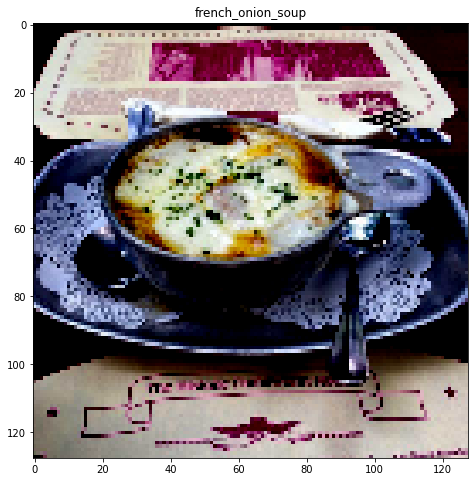

In [3]:
classes = trainset.classes
print(classes)
plt.figure(figsize=(20, 8))

images, labels = next(iter(train_loader))

plt.imshow(np.transpose(images[0], (1, 2, 0)))
plt.title(classes[labels[0]])

### Basic CNN

In [4]:
class BasicCnn(nn.Module):
    def __init__(self, num_classes=len(classes)):
        super(BasicCnn, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} to train the model")

basicCnn_model = BasicCnn(len(classes))
basicCnn_model.to(device)

Using cuda:0 to train the model


BasicCnn(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
 

In [5]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(basicCnn_model.parameters(), lr=0.001, momentum=0.01)

print(f"No. of trainable parameters in the BasicCnn: {sum(p.numel() for p in basicCnn_model.parameters() if p.requires_grad)}")

No. of trainable parameters in the BasicCnn: 25143461


#### EarlyStopping

In [6]:
n_epochs = 5

class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopping(patience=5,
                              min_delta=7)


def train_test_model(net, n_epochs):
    for epoch in range(n_epochs):
        running_loss = 0.0
        er_stop = False
        print("Epoch: ", epoch+1, "/", n_epochs)
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels= inputs.to(device), labels.to(device) 

            optimizer.zero_grad()

            loss = criterion(net(inputs), labels)
            loss.backward()
            optimizer.step()
            
            if early_stopper.early_stop(loss):
                er_stop = True
                break
            running_loss += loss.item()
    
        val_loss = 0.0
        for j, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs, labels= inputs.to(device), labels.to(device) 
        
            val_loss += criterion(net(inputs), labels).item()
    
        if er_stop:
            print("Stopped due to early stopping.")
        print(f'Epoch: {epoch + 1}, trianing loss: {running_loss / 2000:.3f}, val loss: {val_loss/len(test_loader):.3f}')
        running_loss = 0.0
        val_loss = 0.0

    print('Training Done.....')
    
    test_acc = 0
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels= inputs.to(device), labels.to(device) 
        
        _, preds = torch.max(net(inputs), 1)
        test_acc += torch.sum(preds == labels).item()
            
    print(f"Test accuracy: {test_acc/len(test_loader)}")

In [7]:
train_test_model(basicCnn_model, 5)

Epoch:  1 / 5
Epoch: 1, trianing loss: 10.668, val loss: 4.755
Epoch:  2 / 5
Epoch: 2, trianing loss: 9.913, val loss: 4.918
Epoch:  3 / 5
Epoch: 3, trianing loss: 9.484, val loss: 4.965
Epoch:  4 / 5
Epoch: 4, trianing loss: 9.067, val loss: 5.000
Epoch:  5 / 5
Epoch: 5, trianing loss: 8.668, val loss: 5.001
Training Done.....
Test accuracy: 0.4825839138695377


### All Convolutional Net

In [8]:
class ALL_CNN(nn.Module):
    
    def __init__(self, num_classes = 10):
        
        super().__init__()
        
        self.model_name = 'ALL_CNN'
        
        self.dp0 = nn.Dropout2d(p = 0.2)
        
        self.conv1 = nn.Conv2d(3, 96, 3, padding = 1)
        
        self.conv2 = nn.Conv2d(96, 96, 3, padding = 1)

        self.conv3 = nn.Conv2d(96, 96, 3, stride = 2, padding = 1)
        self.dp1 = nn.Dropout2d(p = 0.5)
        
        self.conv4 = nn.Conv2d(96, 192, 3, padding = 1)
        
        self.conv5 = nn.Conv2d(192, 192, 3, padding = 1)
        
        self.conv6 = nn.Conv2d(192, 192, 3, stride = 2, padding = 1)
        self.dp2 = nn.Dropout2d(p = 0.5)
        
        
        
        self.conv7 = nn.Conv2d(192, 192, 3, padding = 0)
        
        self.conv8 = nn.Conv2d(192, 192, 1)
        
        self.conv9 = nn.Conv2d(192, 10, 1)
        
        self.avg = nn.AvgPool2d(6)
        self.fc = nn.Linear(250, num_classes)
        
        
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.xavier_normal_(self.conv3.weight)
        nn.init.xavier_normal_(self.conv4.weight)
        nn.init.xavier_normal_(self.conv5.weight)
        nn.init.xavier_normal_(self.conv6.weight)
        nn.init.xavier_normal_(self.conv7.weight)
        nn.init.xavier_normal_(self.conv8.weight)
        nn.init.xavier_normal_(self.conv9.weight)
        
        '''
        for m in self.modules():
            name = m.__class__.__name__
            if name.find is 'Conv':
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
        '''
        
    def forward(self, x):
        
        x = self.dp0(x)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.dp1(x)
        
        
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.dp2(x)
        
        
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.avg(x)
        x = torch.flatten(x, 1)
        return self.fc(x)
    
allcnn = ALL_CNN(len(classes))
allcnn.to(device)

ALL_CNN(
  (dp0): Dropout2d(p=0.2, inplace=False)
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (dp1): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (dp2): Dropout2d(p=0.5, inplace=False)
  (conv7): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1))
  (conv9): Conv2d(192, 10, kernel_size=(1, 1), stride=(1, 1))
  (avg): AvgPool2d(kernel_size=6, stride=6, padding=0)
  (fc): Linear(in_features=250, out_features=101, bias=True)
)

In [9]:
optimizer = optim.SGD(allcnn.parameters(), lr=0.001, momentum=0.9)
pytorch_total_params = sum(p.numel() for p in allcnn.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {pytorch_total_params}")

Total number of trainable parameters: 1395089


In [10]:
train_test_model(allcnn, 5)

Epoch:  1 / 5
Epoch: 1, trianing loss: 10.928, val loss: 4.615
Epoch:  2 / 5
Epoch: 2, trianing loss: 10.898, val loss: 4.554
Epoch:  3 / 5
Epoch: 3, trianing loss: 10.719, val loss: 4.481
Epoch:  4 / 5
Epoch: 4, trianing loss: 10.588, val loss: 4.437
Epoch:  5 / 5
Epoch: 5, trianing loss: 10.511, val loss: 4.393
Training Done.....
Test accuracy: 0.642811906269791


### Regularization

In [11]:
batch_size = 16

trainset = Food101(root='./data', split='train', download=True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                                     transforms.RandomCrop((120,120)),
                                                                     transforms.RandomVerticalFlip(0.4),
                                                                     transforms.RandomHorizontalFlip(0.4),
                                                                     transforms.Resize((128, 128))]))

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = Food101(root='./data', split='test', download=True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                                     transforms.RandomCrop((120,120)),
                                                                     transforms.RandomVerticalFlip(0.4),
                                                                     transforms.RandomHorizontalFlip(0.4),
                                                                     transforms.Resize((128, 128))]))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:
model = BasicCnn(len(classes))
model.to(device)

BasicCnn(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
 

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.01)

print(f"No. of trainable parameters in the BasicCnn: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

No. of trainable parameters in the BasicCnn: 25143461


In [14]:
train_test_model(model, 5)

Epoch:  1 / 5
Epoch: 1, trianing loss: 10.857, val loss: 4.673
Epoch:  2 / 5
Epoch: 2, trianing loss: 10.636, val loss: 4.741
Epoch:  3 / 5
Epoch: 3, trianing loss: 10.535, val loss: 4.777
Epoch:  4 / 5
Epoch: 4, trianing loss: 10.453, val loss: 4.801
Epoch:  5 / 5
Epoch: 5, trianing loss: 10.368, val loss: 4.832
Training Done.....
Test accuracy: 0.1804939835338822


### Transfer Learning

In [15]:
model_ft = models.resnet18(pretrained=True)
res_mod = torchvision.models.resnet18(pretrained=True)
res_mod.fc = nn.Linear(model_ft.fc.in_features, len(classes))

res_mod = res_mod.to(device)
res_mod

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
res_optim = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(res_optim, step_size=7, gamma=0.1)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    
    dataloaders = {'train':train_loader, 'val':test_loader}
    dataset_sizes = {'train': len(train_loader), 'val': len(test_loader)}
    
    best_model_wts, best_acc = copy.deepcopy(model.state_dict()), 0.0 
    train_acc_his, train_loss_his, val_acc_his, val_loss_his = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')

        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode
                model.train()  
            else:
                # Set model to evaluate mode
                model.eval()   

            running_loss, running_corrects = 0.0, 0
            
            
            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device) 

                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss_his.append(epoch_loss)
                train_acc_his.append(epoch_acc)
            else:
                val_loss_his.append(epoch_loss)
                val_acc_his.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    history = [train_acc_his, train_loss_his, val_acc_his, val_loss_his]
    return model, history

In [18]:
res_mod, history = train_model(res_mod, criterion, res_optim, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
train Loss: 68.7181 Acc: 1.2608
val Loss: 59.5601 Acc: 2.8062

Epoch 1/4
train Loss: 59.4095 Acc: 2.8226
val Loss: 53.7208 Acc: 3.7068

Epoch 2/4
train Loss: 55.8058 Acc: 3.3894
val Loss: 50.5612 Acc: 4.3401

Epoch 3/4
train Loss: 53.8266 Acc: 3.7590
val Loss: 48.7508 Acc: 4.6719

Epoch 4/4
train Loss: 52.4424 Acc: 3.9527
val Loss: 47.6134 Acc: 4.9056

Best val Acc: 4.905636


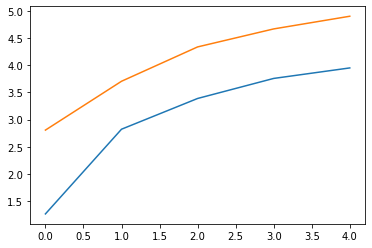

In [19]:
for his in range(len(history)):
    for i in range(len(history[his])):
            
        history[his][i] = float(history[his][i])

plt.plot(range(5), history[0])
plt.plot(range(5), history[2])

#### References:
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html